# Spectrum CNN

Automatic modulation recognition with CNN using spectrogram data based on technique from Zeng et al's paper "Spectrum Analysis and Convolutiopnal Neural Netowrk for Automatic Modulation Recognition" published in IEEE Wireless Communications Letters, Vol 8, No 3, of June 2019.

This example deviates from Zeng et al's in tje following ways:

- Spectrogram data (CNN input) is provided as a 2D (time and freqnency) array of intensity values as apposed to a 3D (time, frequency, and three color channels) array. This allows Conv2D layers to be used vs Conv3D. This change reduces the number of learned parameters from 199k to 172k.


- The dataset combines spectrograms from multiple SNRs (0 to 18 dB) vs only using a single SNR per model. This is inteded to make the trained model more robust to noise by 1) providing more training data, and 2) providing a wider variety of data due to various ammounts of noise present.

In [1]:
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense



import iq_utils as iq
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

The following cell can be run to reload the iq_utils modlue after editing during notebook testing

In [ ]:
from importlib import reload
reload(iq)

## Load data

In [24]:
spec_dict = iq.from_pickle('spectrogram_dict_18_3c')

In [25]:
X_train, y_train, X_test, y_test = iq.process_data(spec_dict, test_split=0.0, blur=False)

In [26]:
print('There are {} samples in the trianing set and {} in the testing set'.format(X_train.shape[0], X_test.shape[0]))

There are 11000 samples in the trianing set and 0 in the testing set


## Build model

In [12]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=X_train.shape[1:], padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(12, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(8, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(11, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 12)        3468      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 12)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 8)        

## Train model
Zeng et al does not discuss the size of batches used or if overfitting occured

In [27]:
history_SCNN2 = model.fit(X_train, y_train, batch_size=128, epochs=40, validation_split=0.1, verbose=1)

Train on 9900 samples, validate on 1100 samples
Epoch 1/40
9900/9900 [==============================] - 5s 460us/sample - loss: 5.9505 - accuracy: 0.4397 - val_loss: 0.8117 - val_accuracy: 0.6473
Epoch 2/40
9900/9900 [==============================] - 4s 447us/sample - loss: 0.7050 - accuracy: 0.6932 - val_loss: 0.5911 - val_accuracy: 0.7418
Epoch 3/40
9900/9900 [==============================] - 5s 459us/sample - loss: 0.5642 - accuracy: 0.7464 - val_loss: 0.5365 - val_accuracy: 0.7455
Epoch 4/40
9900/9900 [==============================] - 5s 462us/sample - loss: 0.5163 - accuracy: 0.7708 - val_loss: 0.5402 - val_accuracy: 0.7555
Epoch 5/40
9900/9900 [==============================] - 5s 471us/sample - loss: 0.4742 - accuracy: 0.7858 - val_loss: 0.4608 - val_accuracy: 0.7773
Epoch 6/40
9900/9900 [==============================] - 5s 469us/sample - loss: 0.4444 - accuracy: 0.7983 - val_loss: 0.4454 - val_accuracy: 0.7936
Epoch 7/40
9900/9900 [==============================] - 5s 484us

## View training stats

The following cell shows training of dataset using 18 dBm SNR only and the SCNN methodology on 3 channels of data (mag, phase, angle).

 - Model was trained for 40 epochs (~45s per epoch training time)
 - Batch size = 128
 - Train/test split of 0.1 was used
 - Of the training data, a 0.1 validation split was used.
 
The dataset has 11,0000 examples (1,000 of each modulation technique and SNR).

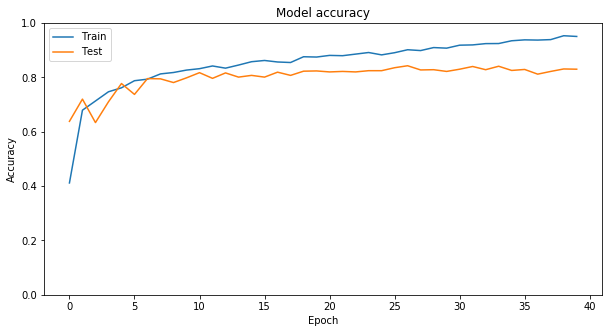

In [17]:
plt.plot(history_SCNN2.history['accuracy'])
plt.plot(history_SCNN2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Test'], loc='upper left')c
plt.show()

The following cell shows training of dataset consisting of 2 dBm SNR only and the SCNN methodology on 3 channels of data (mag, phase, angle). The model was pretrained on 18 dBm SNR dataset for 40 epochs.

 - Model was trained for 40 epochs (~4s per epoch training time)
 - Batch size = 128
 - No test set was used
 - Trainig data was split with validation split of 0.1

Dataset consits of 11,000 total examples with 1,000 examples of each modulation technique.

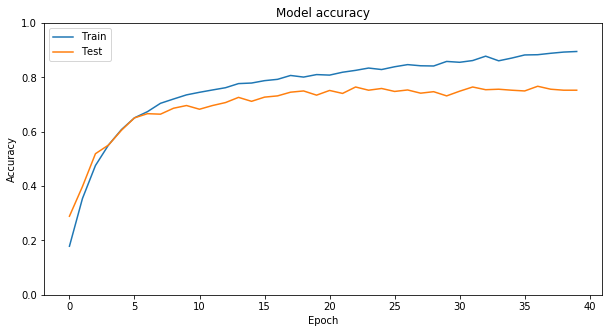

In [23]:
plt.plot(history_SCNN2.history['accuracy'])
plt.plot(history_SCNN2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The following cell shows training of dataset using 18 dBm SNR only and the SCNN methodology on 3 channels of data (mag, phase, angle). The model was pretrained on 18 dBm SNR dataset for 40 epochs and 2 dBm SNR dataset for 40 epochs.

 - Model was trained for 40 epochs (~45s per epoch training time)
 - Batch size = 128
 - Train/test split of 0.1 was used
 - Of the training data, a 0.1 validation split was used.
 
The dataset has 11,0000 examples (1,000 of each modulation technique and SNR).

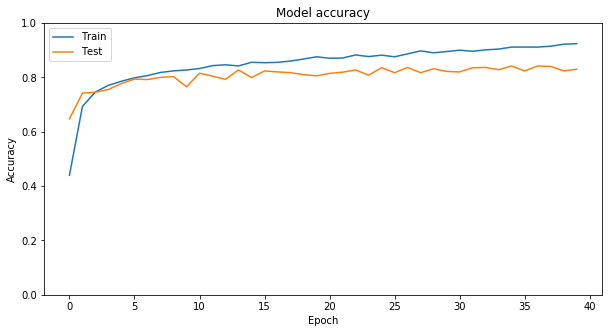

In [29]:
plt.plot(history_SCNN2.history['accuracy'])
plt.plot(history_SCNN2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Evaluate model
TODO: this uses the training data as no seperate test data was set aside. There was discussion online about this, need to look into if further.

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=128)
print("Loss:\t\t{}\nAccuracy:\t{}".format(loss, accuracy))

## Save model

In [ ]:
model.save('SCNN2_0_18.model')

## Load model

In [ ]:
model = tf.keras.models.load_model('SCNN_0_18.model')

In [ ]:
model.summary()